In [1]:
import os
import json

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

PROTEIN_NAMES = ("Spike", "N")

HYPHY_DIR = "output/nextstrain_hyphy_results/"
HYPHY_RES_FILE = "output/nextstrain_hyphy_results.csv"
HYPHY_DIFF_FILE = "output/fubar_meme_diff.csv"

HYPHY_DIFF_VENN_PLOT = "plots/hyphy_diff.pdf"


In [2]:
res = []

for fn in os.listdir(HYPHY_DIR):
    for protein in PROTEIN_NAMES:
        fp = os.path.join(HYPHY_DIR, fn, f"{fn}_{protein}.nexus.MEME.json")
        with open(fp) as f:
            hyphy_meme = json.load(f)
        content_names = hyphy_meme["MLE"]["headers"]
        for site, meme_res in enumerate(hyphy_meme["MLE"]["content"]["0"], start=1):
            row = {name[0]: val for name, val in zip(content_names, meme_res)}
            row.update({
                "site": site,
                "protein": protein,
                "date": fn
            })
            res.append(row)
            
res = pd.DataFrame.from_records(res)
res[["site", "p-value", "protein", "date"]].to_csv(HYPHY_RES_FILE, index=False)


In [3]:
fubar_res = []

for fn in os.listdir(HYPHY_DIR):
    for protein in PROTEIN_NAMES:
        fp = os.path.join(HYPHY_DIR, fn, f"{fn}_{protein}.nexus.FUBAR.json")
        with open(fp) as f:
            hyphy_meme = json.load(f)
        content_names = hyphy_meme["MLE"]["headers"]
        for site, meme_res in enumerate(hyphy_meme["MLE"]["content"]["0"], start=1):
            row = {name[0]: val for name, val in zip(content_names, meme_res)}
            row.update({
                "site": site,
                "protein": protein,
                "date": fn
            })
            fubar_res.append(row)
            
fubar_res = pd.DataFrame.from_records(fubar_res)


In [4]:
res["meme"] = res["p-value"] < 0.1
fubar_res["fubar"] = fubar_res["Prob[alpha<beta]"] >= 0.9

In [5]:
meme_fubar_comparison = pd.merge(
    res[["site", "meme", "protein", "date"]],
    fubar_res[["site", "fubar", "protein", "date"]],
    on=("site", "protein", "date")
)
meme_fubar_comparison = meme_fubar_comparison[meme_fubar_comparison["protein"] == "Spike"]
meme_fubar_comparison.to_csv(HYPHY_DIFF_FILE, index=False)


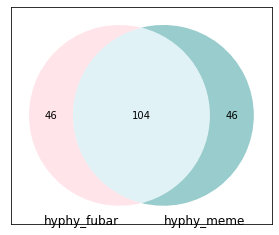

In [6]:
fubar_sites = meme_fubar_comparison.loc[meme_fubar_comparison["fubar"], "site"].unique()
meme_sites = meme_fubar_comparison.loc[meme_fubar_comparison["meme"], "site"].unique()

venn2(
    subsets = [set(fubar_sites), set(meme_sites)],
    set_labels = ("hyphy_fubar", "hyphy_meme"),
    set_colors=("pink", "teal"),
    alpha = 0.4
)
plt.savefig(HYPHY_DIFF_VENN_PLOT, bbox_inches="tight")
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.show()
plt.close()
